# Creating and Testing a Radial Basis Function Neural Network
Author: Rahul Balamurugan

Date: 26 June 2021

This notebook contains the design of RBF NNs to approximate a function mapping and comparison of 3 different designs based on their performance in approximation. The NNs have Gaussian activation function, with differences being in the number of centers and method of selecting centers. In the first NN (Part 1), each input wass taken as a center, and the accuracy for a range of spread parameters was studied. In both the second and third NNs (Part 2), the number of centers was set to 150, with selection being random picking from the input set in case of the former and using k-means clustering for the latter. The overall performances of the NN designs in both parts were also compared at the end.

In [1]:
import numpy as np
import random
from random import seed
import matplotlib.pyplot as plt
random.seed(0)
np.random.seed(0)

## Creating datasets for training and testing:
### The complete dataset:
The problem required the dataset contain all the points $(x_i,x_j)$ satisfying $-2\leq x_i,x_j\geq2$ and $x_i = -2 +0.2*i$, i = 0,1,...,20 (same for $x_j$). This was done below using the cartesian product of $x_i$ and $x_j$ in the cartesian_product(arrays to be crossed) function. The function was referenced from Senderles' answer to https://stackoverflow.com/a/11146645.

In [2]:
def cartesian_product(*arrays):
    la = len(arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype='float64')
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

In [3]:
x_i = np.array([(-2+0.2*i) for i in range(21)])
data = cartesian_product(x_i,x_i)

In [4]:
data.shape

(441, 2)

### Labels for the complete dataset:
The labels for the input dataset were obtained from the mapping function given by:
\begin{equation}
    f(x_1,x_2)= 
\begin{cases}
     1,& \text{if } x_1^2+x_2^2\leq 1\\
    -1,& \text{if } x_1^2+x_2^2\geq 1
\end{cases}
\end{equation}
The mapping function was implemented in the mapper(data) function below.

In [5]:
def mapper(data):
    if isinstance(data,list):
        data = np.array(data) #if data is list
        
    arr = np.empty([data.shape[0],1], dtype='float64')
    for i in range(data.shape[0]):
        x_i_2 = data[i,0]**2
        x_j_2 = data[i,1]**2
        sum_squares = x_i_2 + x_j_2
        if sum_squares <= 1:
            arr[i] = 1
        else:
            arr[i] = -1
    return arr

In [6]:
labels = mapper(data)

In [7]:
labels.shape

(441, 1)

### Dataset visualization:
The dataset is plotted below, where the blue points are those mapped as $f(x)=1$ and red points are those mapped as $f(x)=-1$. The circle is a representation of the mapping function conditions.

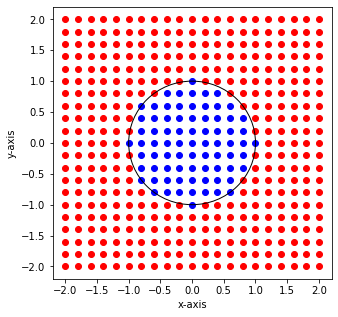

In [8]:
class1 = np.array([x for x in data.tolist() if mapper([x])==1])
class2 = np.array([x for x in data.tolist() if mapper([x])==-1])

fig,ax = plt.subplots(figsize=(5,5))
plt.scatter(class1[:,0],class1[:,1],c='b')
plt.scatter(class2[:,0],class2[:,1],c='r')
plt.xlabel("x-axis")
plt.ylabel("y-axis")
circle1 = plt.Circle((0, 0), 1, ec='k', fill = False)
ax.add_patch(circle1)
plt.show()

### Splitting into training and testing datasets:
The dataset obtained was split into training and testing datasets in the suggested ratio of 80:20 by random selection. 

In [9]:
training_size = int(0.8*data.shape[0])
#Select indices for training set by random selection (without duplicates):
training_idx = np.random.permutation(data.shape[0])[:training_size]
#Test set indices are those left over after training set selection:
test_idx = np.array([x for x in range(data.shape[0]) if x not in training_idx])

training_data, test_data = data[training_idx,:], data[test_idx,:]
training_labels, test_labels = labels[training_idx,:], labels[test_idx,:]

In [10]:
training_data.shape

(352, 2)

In [11]:
test_data.shape

(89, 2)

## Common functions for both parts 1 and 2(a,b):

*NOTE: In case of the Gaussian activation function, the width parameter is called 'spread' and its value in text sometimes as 'spread value' throughout the rest of this notebook. In the actual function, the **spread is '$\sigma$'** and is constant for the entire hidden layer, which is the original setting of the RBF. The Gaussian basis function is:* 
\begin{equation}
G_{ij} = e^-\frac{||x_i-c_j||^2}{2*\sigma^2}
\end{equation}

In [12]:
def Gauss_kernel(inputs,centers,spread):
    #To get Gaussian kernels.
    G = np.empty([inputs.shape[0],centers.shape[0]], dtype='float64')
    for ci, c in enumerate(centers):
        for xi, x in enumerate(inputs):
            G[xi,ci] = np.exp(-(np.linalg.norm(c-x)**2)/(2*spread**2))
    return G

In [13]:
def weights(G,labels):
    #To calculate weights between the hidden and output layers, the function implements the explicit solution of the 
    #minimization problem E(W)=||GW-Y_true||^2, given by W = (G+)Y_true, where G+ is the pseudoinverse of G.
    G_t = np.transpose(G)
    W = np.empty([labels.shape[0],1], dtype='float64')
    W = np.linalg.inv(G_t @ G) @ G_t @ labels
    #NOTE: [np.linalg.inv(G_t @ G) @ G_t] is pseudo-inverse of G
    return W

In [14]:
def test_RBF(G,W):
    #To get output of the model using the weights and gaussian activations.
    Y = G @ W
    for x in range(Y.shape[0]):
        if Y[x]>=0:
            Y[x] = 1
        else:
            Y[x] = -1
    return Y

In the test_RBF function, the outputs obtained from G x W matrix multiplication are divided into the two classes (1 or -1) based on which side of the line y = 0 the elements of the 1D array Y fall on. 

## Part 1:
The spread values were kept the same for all kernels functions; number of centers was the same as the number of inputs as each input was taken as a center. 

In the below cell, training involves the model learning the weights and testing involves getting the values of the mapping function approximation by multiplying the values from the activated hidden nodes (from function Gauss_kernel) with the trained weights. The training and testing process was done for 20 evenly spaced spread values from 0.1 to 2. The mean square error (MSE) of approximation was then plotted for Part 1. 

In [15]:
train_MSE = list()
test_MSE = list()
centers_1 = training_data
W_1 = np.empty([centers_1.shape[0],1], dtype='float64')
spread_range = np.arange(0.1,2.1,0.1)

for spread in spread_range:
    
    #Train the RBF NN:
    G = Gauss_kernel(training_data, centers_1, spread)
    W_1 = weights(G,training_labels)

    #Test the RBF NN:
    Y = test_RBF(G,W_1)

    #Calculate train MSE:
    train_MSE.append(np.square(np.subtract(training_labels,Y)).mean())
    
    #Test on testing set:
    G_test = Gauss_kernel(test_data, centers_1, spread)
    Y_test = test_RBF(G_test,W_1)
            
    #Calculate test MSE:
    test_MSE.append(np.square(np.subtract(test_labels,Y_test)).mean())

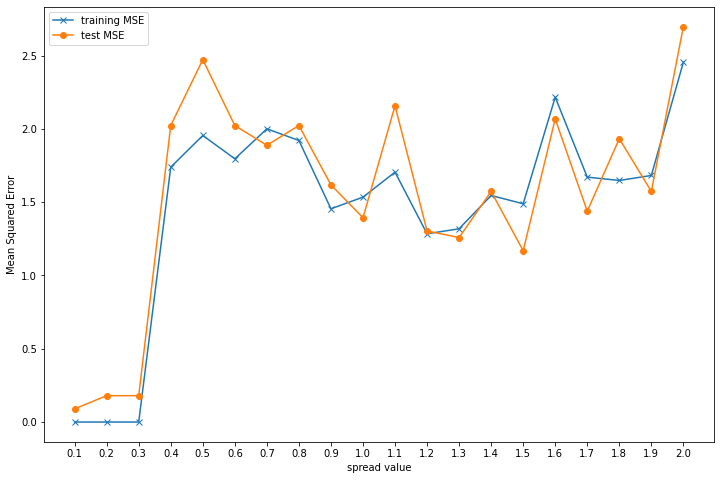

In [16]:
#Plotting MSE against spread value:
plt.figure(figsize=(12,8))
plt.plot(spread_range,train_MSE,marker = 'x')
plt.plot(spread_range,test_MSE, marker = 'o');
plt.xticks(spread_range)
plt.xlabel("spread value")
plt.ylabel("Mean Squared Error")
plt.legend(["training MSE", "test MSE"])
plt.show()

From the observed results, the MSE was 0 for the training set until spread = 0.3, after which there was a relatively steep rise in MSE. Since the square of the spread value is what influences the Gaussian kernel, the difference between the two values is very low since they are lesser than 1, after which the square increases quadratically. Anyway, such a result was expected since the weights solved using the inverse of the activations matrix are the most optimal weights, and on the training data with appropriate Gaussian kernels, the outputs should be (and are) the same as the target outputs. It appears that the model performed best at spread = 0.1 and has slightly worser performance at spread = 0.2 or 0.3 when tested on the test dataset- which follows the results for the training set closely, showing that for this approximation and given the inputs are taken as the centers, the best width value is 0.1. 

## Part 2(a):
The number of centers were kept at 150, with spread values still being the same for all kernel functions. In this case, the centers were selected randomly from the input dataset. To look at how the MSE varies with each random selection, 2 different seed values were chosen and the MSE for each selection was plotted. The plot describes how the MSE varies with the spread values for each random selection of centers.

In [17]:
train_MSE_2a = [[] for i in range(6)]
test_MSE_2a = [[] for i in range(6)]

spread_range = np.arange(0.1,2.1,0.1)
n_centers = 150
centers_2a = np.empty((2,n_centers,2), dtype = 'float64')
W_2a = np.empty([n_centers,1], dtype='float64')
for i in [0,1]:
    np.random.seed(i)
    centers_idx = np.random.permutation(training_data.shape[0])[:n_centers]
    centers_2a[i] = training_data[centers_idx,:]

    for spread in spread_range:

        #Train the RBF NN:
        G = Gauss_kernel(training_data, centers_2a[i], spread)
        W_2a = weights(G,training_labels)

        #Test the RBF NN:
        Y = test_RBF(G,W_2a)

        #Calculate train MSE:
        train_MSE_2a[i].append(np.square(np.subtract(training_labels,Y)).mean())

        #Test on testing set:
        G_test = Gauss_kernel(test_data, centers_2a[i], spread)
        Y_test = test_RBF(G_test,W_2a)

        #Calculate test MSE:
        test_MSE_2a[i].append(np.square(np.subtract(test_labels,Y_test)).mean())
np.random.seed(0)

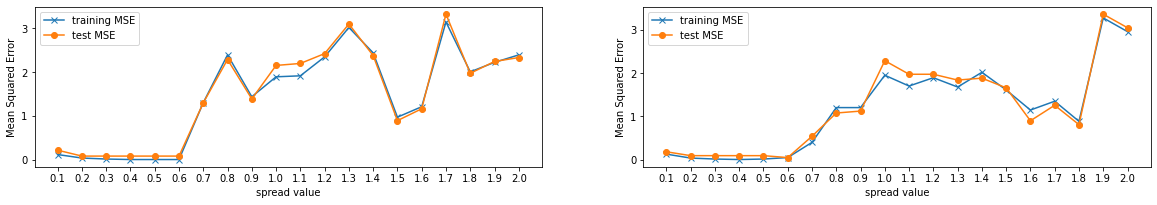

In [18]:
#Plotting MSE against spread for 6 random selections of centers:
fig = plt.figure(figsize=(20,10))
for i in [0,1]:
    fig.add_subplot(3,2,i+1)
    plt.plot(spread_range,train_MSE_2a[i],marker = 'x')
    plt.plot(spread_range,test_MSE_2a[i], marker = 'o');
    plt.xticks(spread_range)
    plt.xlabel("spread value")
    plt.ylabel("Mean Squared Error")
    plt.legend(["training MSE", "test MSE"])
plt.show()

In both of the plots above, it could be observed that at spread value = 0.3 the MSE was 0 for the training set and very close to zero for the test set. This implied that 0.3 is the best spread value, and that random selection of centers did not affect much the performance of the RBF NN as an approximator of the given mapping function at low spread values (below 0.6). This can be attributed to the fact that the inputs are arranged spatially in an evenly distributed square grid, and that a uniform random selection of a considerable sample size (i.e., 150 compared to the 441 total possible) means the distribution of centers would be somewhat normal, which is naturally ideal for this problem. The 2 random selection of centers are plotted below.

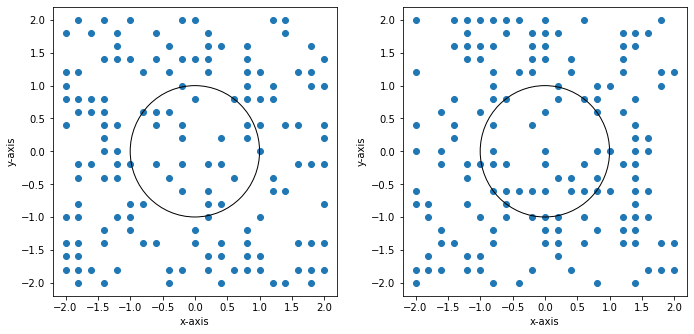

In [19]:
#Plotting the centers:
fig = plt.figure(figsize=(10,5))
for i in [0,1]:
    ax = fig.add_subplot(1,2,i+1)
    plt.scatter(centers_2a[i,:,0],centers_2a[i,:,1])
    plt.xlabel("x-axis")
    plt.ylabel("y-axis")
    circle1 = plt.Circle((0, 0), 1, ec='k', fill = False)
    ax.add_patch(circle1)
fig.tight_layout(pad=2)
plt.show()

As observed, the small value of the spread function (0.3) for the RBF hidden layer activation and the rather uniform distribution of centers, besides the basic nature of the mapping operation, ensures that random selection from the inputs does not impact the performance of the model.

## Part 2(b):
The number of centers were kept at 150, with spread values still being the same for all kernel functions. The centers were calculated using the k-means algorithm. To implement the algorithm, the KMeans function from the sklearn.cluster library was used. Similar to part 1, the performance of the model at different spread values were plotted.

In [20]:
def kmeans_centers(inputs,n_centers):
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=n_centers, random_state=0).fit(inputs)
    return kmeans.cluster_centers_

In [21]:
train_MSE_2b = list()
test_MSE_2b = list()
n_centers = 150
W_2b = np.empty([n_centers,1], dtype='float64')
spread_range = np.arange(0.1,2.1,0.1)

centers_2b = kmeans_centers(training_data,n_centers)

for spread in spread_range:
    
    #Train the RBF NN:
    G = Gauss_kernel(training_data, centers_2b, spread)
    W_2b = weights(G,training_labels)

    #Test the RBF NN:
    Y = test_RBF(G,W_2b)

    #Calculate train MSE:
    train_MSE_2b.append(np.square(np.subtract(training_labels,Y)).mean())
    
    #Test on testing set:
    G_test = Gauss_kernel(test_data, centers_2b, spread)
    Y_test = test_RBF(G_test,W_2b)
            
    #Calculate test MSE:
    test_MSE_2b.append(np.square(np.subtract(test_labels,Y_test)).mean())

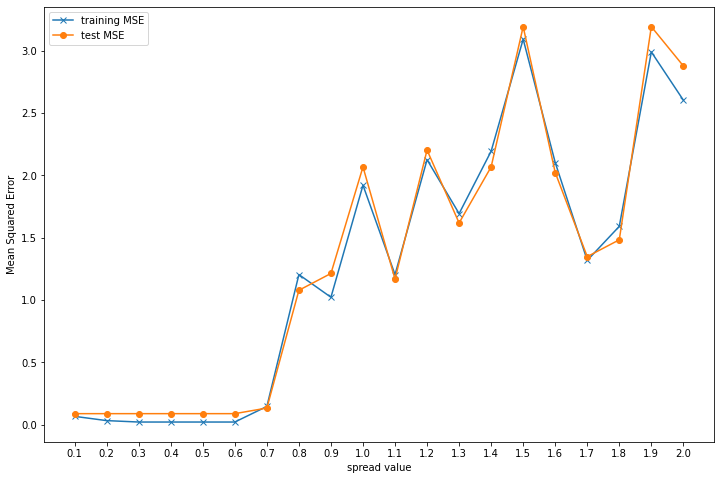

In [22]:
#Plotting MSE against spread value:
plt.figure(figsize=(12,8))
plt.plot(spread_range,train_MSE_2b,marker = 'x')
plt.plot(spread_range,test_MSE_2b, marker = 'o');
plt.xticks(spread_range)
plt.xlabel("spread value")
plt.ylabel("Mean Squared Error")
plt.legend(["training MSE", "test MSE"])
plt.show()

Compared to the previous two models which used one-phase learning scheme, the main difference in this Part 2(b) is the two-phase learning where first, the Gaussian kernel centers are learned through unsupervised k-means clustering, and then the weights are learned. From the above plot, however, the results are very similar to the random selection (part 2(b)). This implies that the centers chosen using the k-means algorithm are similar to random selection, which is corroborated by the plot of the centers below.

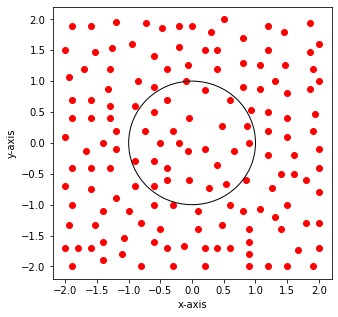

In [23]:
fig,ax = plt.subplots(figsize=(5,5))
plt.scatter(centers_2b[:,0],centers_2b[:,1],c='r')
plt.xlabel("x-axis")
plt.ylabel("y-axis")
circle1 = plt.Circle((0, 0), 1, ec='k', fill = False)
ax.add_patch(circle1)
plt.show()

## Performance comparison:
The mean square errors for fixed spread values [0.1, 0.2, 0.3] are found by testing the 3 trained models from parts 1 and 2(a and b) on the test set. The observations are plotted below.

In [24]:
MSE_1 = list()
MSE_2a = list()
MSE_2b = list()
spread_range = [0.1,0.2,0.3,0.4]
for spread in spread_range:
    #Model from Part 1: train and test
    G = Gauss_kernel(training_data, centers_1, spread)
    W_1 = weights(G,training_labels)
    G_1 = Gauss_kernel(test_data, centers_1, spread)
    Y_1 = test_RBF(G_1,W_1)
    MSE_1.append(np.square(np.subtract(test_labels,Y_1)).mean())
    
    #Model from Part 2(a):
    G = Gauss_kernel(training_data, centers_2a[0], spread)
    W_2a = weights(G,training_labels)
    G_2a = Gauss_kernel(test_data, centers_2a[0], spread)
    Y_2a = test_RBF(G_2a,W_2a)
    MSE_2a.append(np.square(np.subtract(test_labels,Y_2a)).mean())
    
    #Model from Part 2(b)
    G = Gauss_kernel(training_data, centers_2b, spread)
    W_2b = weights(G,training_labels)
    G_2b = Gauss_kernel(test_data, centers_2b, spread)
    Y_2b = test_RBF(G_2b,W_2b)
    MSE_2b.append(np.square(np.subtract(test_labels,Y_2b)).mean())

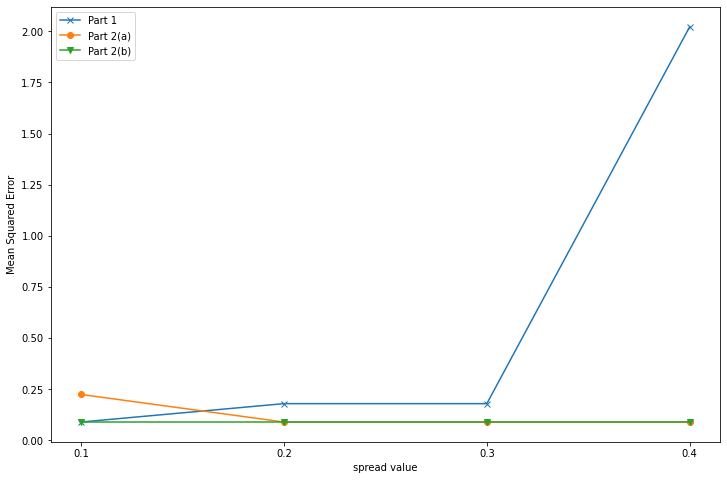

In [25]:
#Plotting MSE against spread value:
plt.figure(figsize=(12,8))
plt.plot(spread_range,MSE_1,marker = 'x')
plt.plot(spread_range,MSE_2a, marker = 'o');
plt.plot(spread_range,MSE_2b, marker = 'v');
plt.xticks(spread_range)
plt.xlabel("spread value")
plt.ylabel("Mean Squared Error")
plt.legend(["Part 1", "Part 2(a)", "Part 2(b)"])
plt.show()

In [26]:
MSE_val = MSE_2a[1]
MSE_val

0.0898876404494382

From the above plot, it can be observed that the RBF NN design in Part 2(b) performed the best, i.e., had the lowest mean square error at more spread values than the other two models. Note that at spread = 0.1, models in Part 1 and Part 2(b) had the same performance, and at spread = 0.2,0.3, and 0.4, models in Part 2(a) and 2(b) had the same performance. The MSE for the test set approximation by the model in Part 2(b) remained constant for all the 4 spread values, and this is taken as the best performance. As noted above, this lowest MSE value is ~0.09.

Although the comparisons are not very conclusive, it can be said that in the scope of the investigation in this experiment, the performance of the RBF neural network using a two-phase learning scheme, with the first phase learning of kernel centers done through k-means clustering of inputs, is more consistent (and remains at best value) compared to the other two models.